In [4]:
pip install torch

   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   -- ------------------------------------- 15.5/241.3 MB 74.9 MB/s eta 0:00:04
   ----- ---------------------------------- 33.6/241.3 MB 82.0 MB/s eta 0:00:03
   ------- -------------------------------- 48.0/241.3 MB 76.3 MB/s eta 0:00:03
   ---------- ----------------------------- 60.6/241.3 MB 72.8 MB/s eta 0:00:03
   ------------ --------------------------- 72.6/241.3 MB 70.2 MB/s eta 0:00:03
   -------------- ------------------------- 87.3/241.3 MB 69.6 MB/s eta 0:00:03
   ---------------- ---------------------- 101.2/241.3 MB 69.5 MB/s eta 0:00:03
   ------------------ -------------------- 116.9/241.3 MB 69.8 MB/s eta 0:00:02
   --------------------- ----------------- 132.1/241.3 MB 70.3 MB/s eta 0:00:02
   ----------------------- --------------- 148.1/241.3 MB 71.1 MB/s eta 0:00:02
   -------------------------- ------------ 162.8/241.3 MB 71.3 MB/s eta 0:00:02
   --------------------------- ----------- 172.8/

In [15]:
pip install scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 8.7/8.7 MB 60.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   -------------- ------------------------- 13.9/38.6 MB 66.8 MB/s eta 0:00:01
   ------------------------------- -------- 29.9/38.6 MB 75.8 MB/s eta 0:00:01
   ---------------------------------------- 38.6/38.6 MB 64.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [45]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Simulate a binary classification dataset
X, y = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
    random_state=42, n_clusters_per_class=1
)

# 2. Standardize and convert to tensors
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def to_tensor(x, y):
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X_train, y_train = to_tensor(X_train, y_train)
X_val, y_val = to_tensor(X_val, y_val)
X_test, y_test = to_tensor(X_test, y_test)

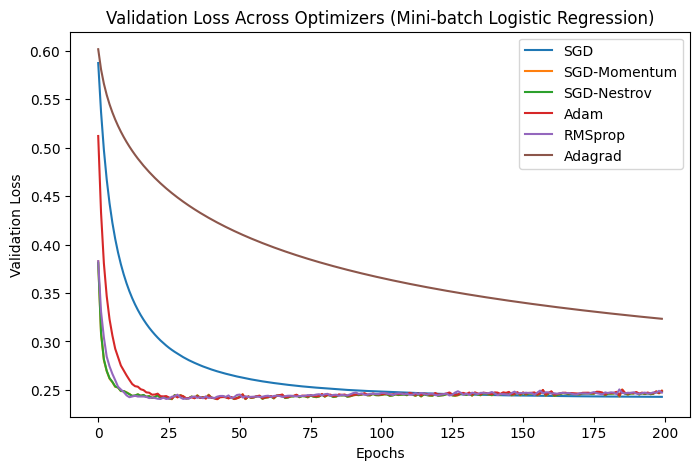

In [47]:

# 3. Define forward pass manually
def logistic_forward(X, W, b):
    return torch.sigmoid(X @ W + b)

# 4. Define hard-coded binary cross-entropy loss
def binary_cross_entropy(y_pred, y_true):
    eps = 1e-8
    return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))


# 5. Training function with minimal default functions
def train_model(optimizer_name, lr=0.01, epochs=200, batch_size=20):
    n_samples, n_features = X_train.shape
    if optimizer_name == 'SGD':
        optimizer = optim.SGD([W, b], lr=lr)
    elif optimizer_name == 'SGD-Momentum':
        optimizer = optim.SGD([W, b], lr=lr, momentum=0.9) 
    elif optimizer_name == 'SGD-Nestrov':
        optimizer = optim.SGD([W, b], lr=lr, momentum=0.9, nesterov=True)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam([W, b], lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop([W, b], lr=lr)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad([W, b], lr=lr)
    else:
        raise ValueError("Unsupported optimizer")

    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        perm = torch.randperm(n_samples)
        epoch_loss = 0.0

        for i in range(0, n_samples, batch_size):
            idx = perm[i:i+batch_size]
            X_batch, y_batch = X_train[idx], y_train[idx]

            optimizer.zero_grad()
            y_pred = logistic_forward(X_batch, W, b)
            loss = binary_cross_entropy(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Compute training and validation loss
        with torch.no_grad():
            train_pred = logistic_forward(X_train, W, b)
            val_pred = logistic_forward(X_val, W, b)
            train_loss = binary_cross_entropy(train_pred, y_train).item()
            val_loss = binary_cross_entropy(val_pred, y_val).item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

# 6. Compare optimizers
optimizers = ['SGD', 'SGD-Momentum', 'SGD-Nestrov', 'Adam', 'RMSprop', 'Adagrad']
results = {}
y_pred_mat = {}

plt.figure(figsize=(8,5))
for opt in optimizers:
    torch.manual_seed(42)
    W = torch.randn((2, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    
    train_losses, val_losses = train_model(opt)
    plt.plot(val_losses, label=f"{opt}")

    with torch.no_grad():
        y_pred_test = logistic_forward(X_test, W, b)
        y_pred_label = (y_pred_test > 0.5).float()
        accuracy = (y_pred_label.eq(y_test).sum().item()) / len(y_test)

    y_pred_mat[opt] = y_pred_label
    results[opt] = accuracy

plt.title("Validation Loss Across Optimizers (Mini-batch Logistic Regression)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()


In [51]:

print("Final Test Accuracies:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Final Test Accuracies:
SGD: 0.8600
SGD-Momentum: 0.8800
SGD-Nestrov: 0.8800
Adam: 0.8800
RMSprop: 0.8667
Adagrad: 0.8667


In [27]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Simulate a binary classification dataset
X, y = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
    random_state=42, n_clusters_per_class=1
)

y = y.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def to_tensor(x, y):
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X_train, y_train = to_tensor(X_train, y_train)
X_val, y_val = to_tensor(X_val, y_val)
X_test, y_test = to_tensor(X_test, y_test)

In [29]:
class ManualBatchNorm:
    def __init__(self, num_features, momentum=0.9, eps=1e-5):
        self.gamma = torch.ones((1, num_features), requires_grad=True)
        self.beta = torch.zeros((1, num_features), requires_grad=True)
        self.running_mean = torch.zeros((1, num_features))
        self.running_var = torch.ones((1, num_features))
        self.momentum = momentum
        self.eps = eps

    def __call__(self, X, training=True):
        if training:
            batch_mean = X.mean(dim=0, keepdim=True)
            batch_var = X.var(dim=0, unbiased=False, keepdim=True)
            X_hat = (X - batch_mean) / torch.sqrt(batch_var + self.eps)
            # Update running stats
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean.detach()
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var.detach()
        else:
            # Use running stats during evaluation
            X_hat = (X - self.running_mean) / torch.sqrt(self.running_var + self.eps)
        return self.gamma * X_hat + self.beta


In [31]:
def logistic_forward(X, W, b):
    return torch.sigmoid(X @ W + b)

def binary_cross_entropy(y_pred, y_true):
    eps = 1e-8
    return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))


In [38]:
def train_model(optimizer_name, lr=0.01, epochs=200, batch_size=64):
    torch.manual_seed(42)
    n_samples, n_features = X_train.shape
    W = torch.randn((n_features, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    bn = ManualBatchNorm(n_features)
    params = [W, b, bn.gamma, bn.beta]

    if optimizer_name == 'SGD':
        optimizer = optim.SGD([W, b], lr=lr)
    elif optimizer_name == 'SGD-Momentum':
        optimizer = optim.SGD([W, b], lr=lr, momentum=0.9) 
    elif optimizer_name == 'SGD-Nestrov':
        optimizer = optim.SGD([W, b], lr=lr, momentum=0.9, nesterov=True)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam([W, b], lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop([W, b], lr=lr)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad([W, b], lr=lr)
    else:
        raise ValueError("Unsupported optimizer")

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        perm = torch.randperm(n_samples)
        epoch_loss = 0.0

        for i in range(0, n_samples, batch_size):
            idx = perm[i:i+batch_size]
            X_batch, y_batch = X_train[idx], y_train[idx]

            optimizer.zero_grad()
            X_norm = bn(X_batch, training=True)  # <-- BN with batch stats
            y_pred = logistic_forward(X_norm, W, b)
            loss = binary_cross_entropy(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validation (uses running mean/var)
        with torch.no_grad():
            X_val_norm = bn(X_val, training=False)
            y_pred_val = logistic_forward(X_val_norm, W, b)
            val_loss = binary_cross_entropy(y_pred_val, y_val).item()

        train_losses.append(epoch_loss / (n_samples // batch_size))
        val_losses.append(val_loss)


    return train_losses, val_losses


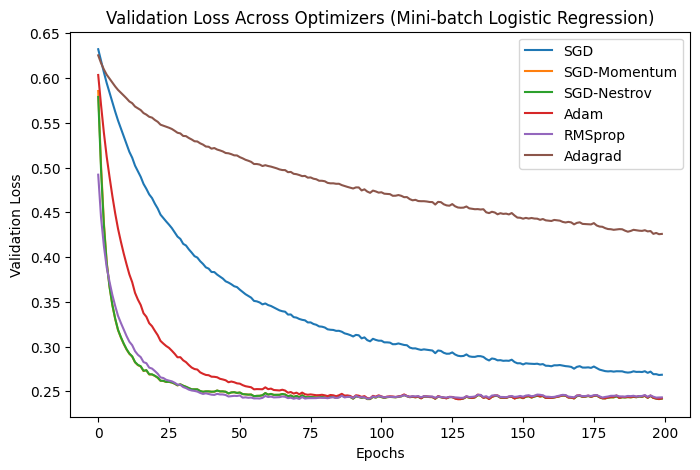

In [41]:
# 6. Compare optimizers
optimizers = ['SGD', 'SGD-Momentum', 'SGD-Nestrov', 'Adam', 'RMSprop', 'Adagrad']
results = {}
y_pred_mat = {}

plt.figure(figsize=(8,5))
for opt in optimizers:
    torch.manual_seed(42)
    W = torch.randn((2, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    
    train_losses, val_losses = train_model(opt)
    plt.plot(val_losses, label=f"{opt}")

    with torch.no_grad():
        y_pred_test = logistic_forward(X_test, W, b)
        y_pred_label = (y_pred_test > 0.5).float()
        accuracy = (y_pred_label.eq(y_test).sum().item()) / len(y_test)

    y_pred_mat[opt] = y_pred_label
    results[opt] = accuracy

plt.title("Validation Loss Across Optimizers (Mini-batch Logistic Regression)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()
